In [2]:
!pip install opendatasets
!pip install pandas
!pip uninstall --yes tensorflow
!pip install tensorflow==2.9.0
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000")

Found existing installation: tensorflow 2.9.0
Uninstalling tensorflow-2.9.0:
  Successfully uninstalled tensorflow-2.9.0
  Using cached tensorflow-2.9.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aryanraj13
Your Kaggle Key: ··········


100%|██████████| 5.20G/5.20G [00:50<00:00, 111MB/s]

In [3]:
import os
import sys
import time
from glob import glob
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

import cv2
from PIL import Image
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

# TensorFlow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from IPython.display import YouTubeVideo
import albumentations as A

# Set environment settings and pandas display options
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Setting styles
sns.set_style('darkgrid')

# Warning settings
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

print('All modules have been imported')

All modules have been imported


In [4]:
base_skin_dir = os.path.join('/', '/content/skin-cancer-mnist-ham10000')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get)
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
3194,HAM_0002775,ISIC_0024407,nv,follow_up,40.0,male,back,/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024407.jpg,Melanocytic nevi,4
8165,HAM_0000717,ISIC_0030455,nv,histo,25.0,female,abdomen,/content/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0030455.jpg,Melanocytic nevi,4
8243,HAM_0004665,ISIC_0030990,nv,histo,40.0,female,foot,/content/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0030990.jpg,Melanocytic nevi,4


In [5]:
df = pd.DataFrame() # columns=["filepaths", "labels"]

df['filepaths'] =tile_df['path']
df['labels'] =tile_df['cell_type_idx']
df['labels'] =df['labels'].apply(lambda x: str(x))
df.head()

,filepaths,labels
0,/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027419.jpg,2
1,/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025030.jpg,2
2,/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026769.jpg,2
3,/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025661.jpg,2
4,/content/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0031633.jpg,2


In [6]:
# This df is useless af
df2 = pd.DataFrame()

df2['filepaths'] = tile_df['path']
df2['labels']    = tile_df['cell_type_idx']
df2['labels']    = df['labels'].apply(lambda x: str(x))
df2['age']       = tile_df['age']
df2['sex']       = tile_df['sex']
df2.head()

,filepaths,labels,age,sex
0,/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027419.jpg,2,80.0,male
1,/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025030.jpg,2,80.0,male
2,/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026769.jpg,2,80.0,male
3,/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025661.jpg,2,80.0,male
4,/content/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0031633.jpg,2,75.0,male


In [7]:
df.labels.unique()


array(['2', '4', '3', '5', '6', '1', '0'], dtype=object)

In [8]:
def split_df(df, trsize, column):
    train_df, dummy_df = train_test_split(df, train_size=trsize, shuffle=True, random_state=14, stratify=df[column])
    valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=14, stratify=dummy_df[column])
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    return train_df, test_df, valid_df

train_df, test_df, valid_df  = split_df(df, .8, 'labels')

train_df length:  8012   test_df length:  1002   valid_df length:  1001


In [9]:
train_df2, test_df2, valid_df2  = split_df(df2, .8, 'labels')


train_df length:  8012   test_df length:  1002   valid_df length:  1001


In [10]:
def plot_label_count (df, plot_title):
    column='labels'
    xaxis_label='CLASS'
    yaxis_label='IMAGE COUNT'
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()
    values=vcounts.tolist()
    lcount=len(labels)
    if lcount>55:
        print_in_color('The number of labels is >55, no plot will be produced')
    else:
        width=lcount * 4
        width=np.min([width, 20])
        plt.figure(figsize=(width,5))
        form = {'family': 'serif', 'color': 'blue', 'size': 25}
        plt.bar(labels, values)
        plt.title(plot_title, fontsize= 24, color='blue')
        plt.xticks(rotation=90, fontsize=18)
        plt.yticks(fontsize=18)
        plt.xlabel(xaxis_label, fontdict=form)
        plt.ylabel(yaxis_label, fontdict=form)
        if lcount >=8:
            rotation='vertical'
        else:
            rotation='horizontal'
        for i in range(lcount):
            plt.text(i, values[i]/2, str(values[i]),fontsize=12, rotation=rotation, color='yellow', ha='center')
        plt.show()

4    5364
5     890
2     879
1     411
0     262
6     114
3      92
Name: labels, dtype: int64


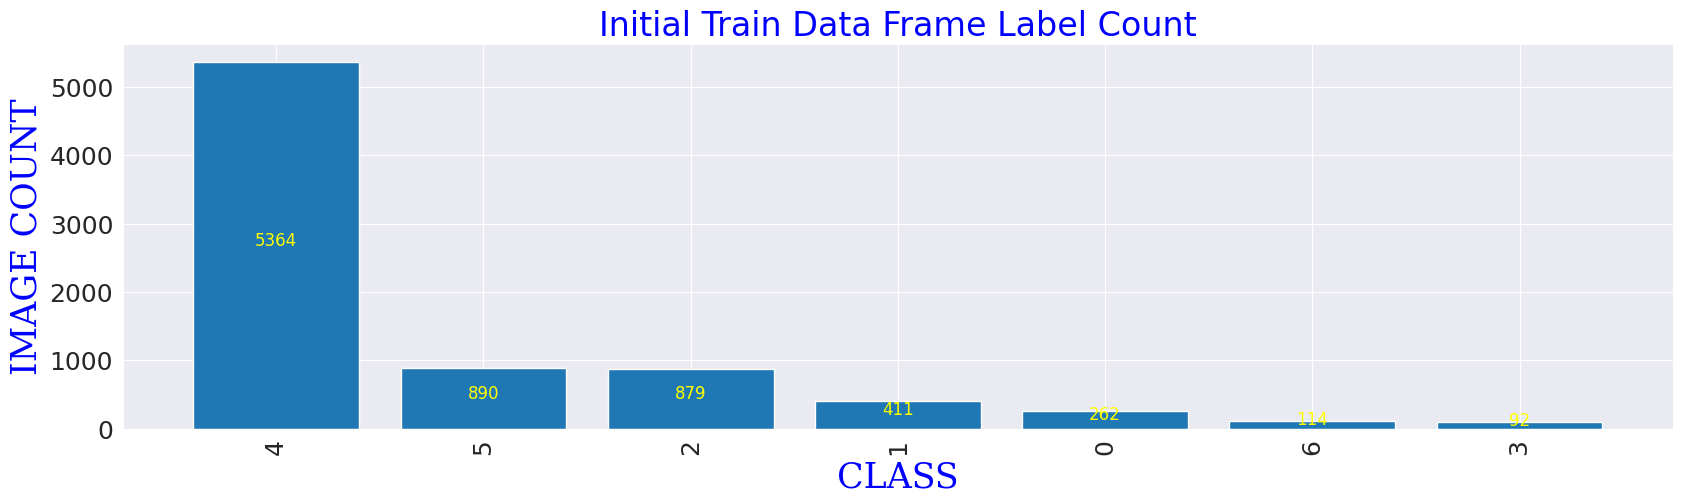

In [11]:
count=train_df['labels'].value_counts()
print (count)
plot_title='Initial Train Data Frame Label Count'
plot_label_count (train_df, plot_title)

In [12]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes= df[column].unique()
    print(classes)
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=1000
min_samples= 10
column='labels'
train_df, classes, class_count= trim(train_df, max_samples, min_samples, column)

['4' '5' '0' '1' '2' '6' '3']
dataframe initially is of length  8012  with  7  classes
after trimming, the maximum samples in any class is now  1000  and the minimum samples in any class is  10
the trimmed dataframe now is of length  3648  with  7  classes


In [14]:
def balance(df, n,column, working_dir, img_size):
    def get_augmented_image(image):
        width=int(image.shape[1]*.8)
        height=int(image.shape[0]*.8)
        transform= A.Compose([
            A.HorizontalFlip(p=.5),
            A.Rotate(limit=30, p=.25),
            A.RandomBrightnessContrast(p=.5),
            A.RandomGamma(p=.5),
            A.RandomCrop(width=width, height=height, p=.25) ])
        return transform(image=image)['image']
    def dummy(image):
        return image

    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df[column].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images
    total=0
    groups=df.groupby(column) # group by class
    for label in df[column].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            desc=f'augmenting class {label}'
            for i in tqdm(range(delta), ncols=120, unit='files', colour='blue',desc=desc):
                j= i % sample_count
                img_path=group['filepaths'].iloc[j]
                img=cv2.imread(img_path)
                img=get_augmented_image(img)
                fname=os.path.basename(img_path)
                fname='aug' +str(i) +'-' +fname
                dest_path=os.path.join(target_dir, fname)
                cv2.imwrite(dest_path, img)
                aug_img_count +=1
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=sorted(os.listdir(classpath))
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

n=1000
working_dir=r'/content/working'
img_size = (310,640)
column='labels'
train_df=balance(train_df, n,column, working_dir, img_size)

Initial length of dataframe is  3648


augmenting class 5:   0%|                                                                    | 0/110 [00:00<?,…

augmenting class 0:   0%|                                                                    | 0/738 [00:00<?,…

augmenting class 1:   0%|                                                                    | 0/589 [00:00<?,…

augmenting class 2:   0%|                                                                    | 0/121 [00:00<?,…

augmenting class 6:   0%|                                                                    | 0/886 [00:00<?,…

augmenting class 3:   0%|                                                                    | 0/908 [00:00<?,…

Total Augmented images created=  3352
Length of augmented dataframe is now  7000


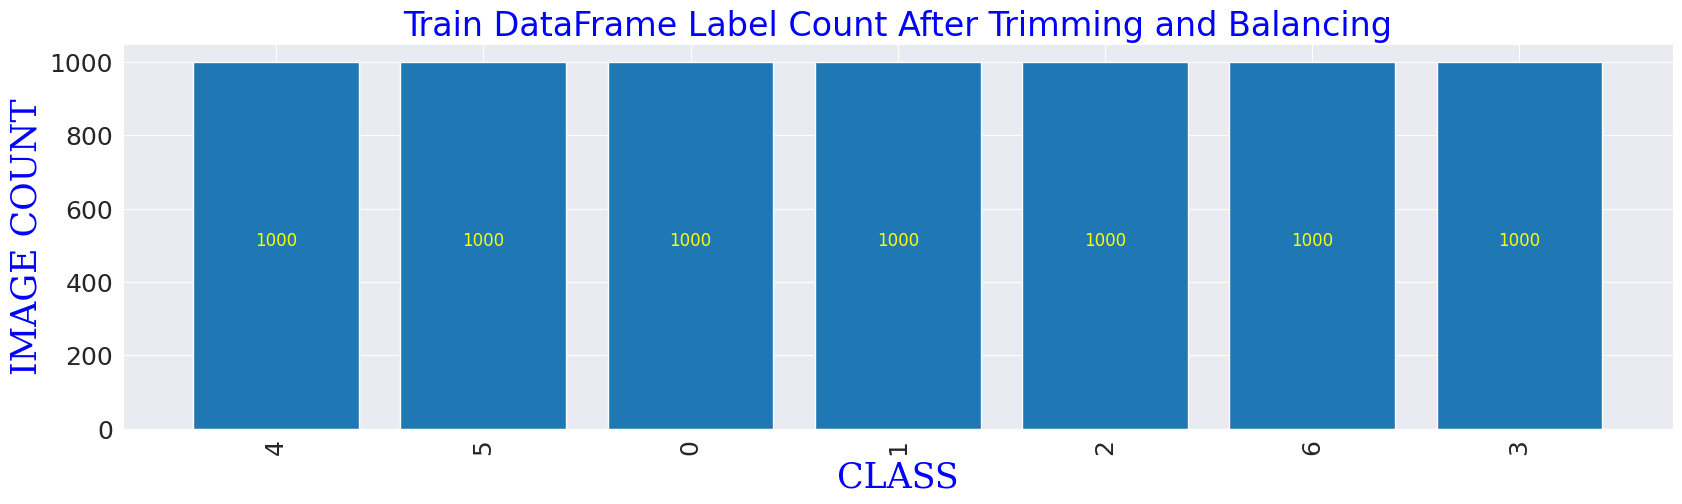

In [15]:
plot_title='Train DataFrame Label Count After Trimming and Balancing'
plot_label_count (train_df, plot_title)

In [16]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps

bs=16
ycol='labels'
train_gen, test_gen, valid_gen, test_steps = make_gens(bs, ycol, train_df, test_df, valid_df, img_size)

Found 7000 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.
test batch size:  6   test steps:  167  number of classes :  7


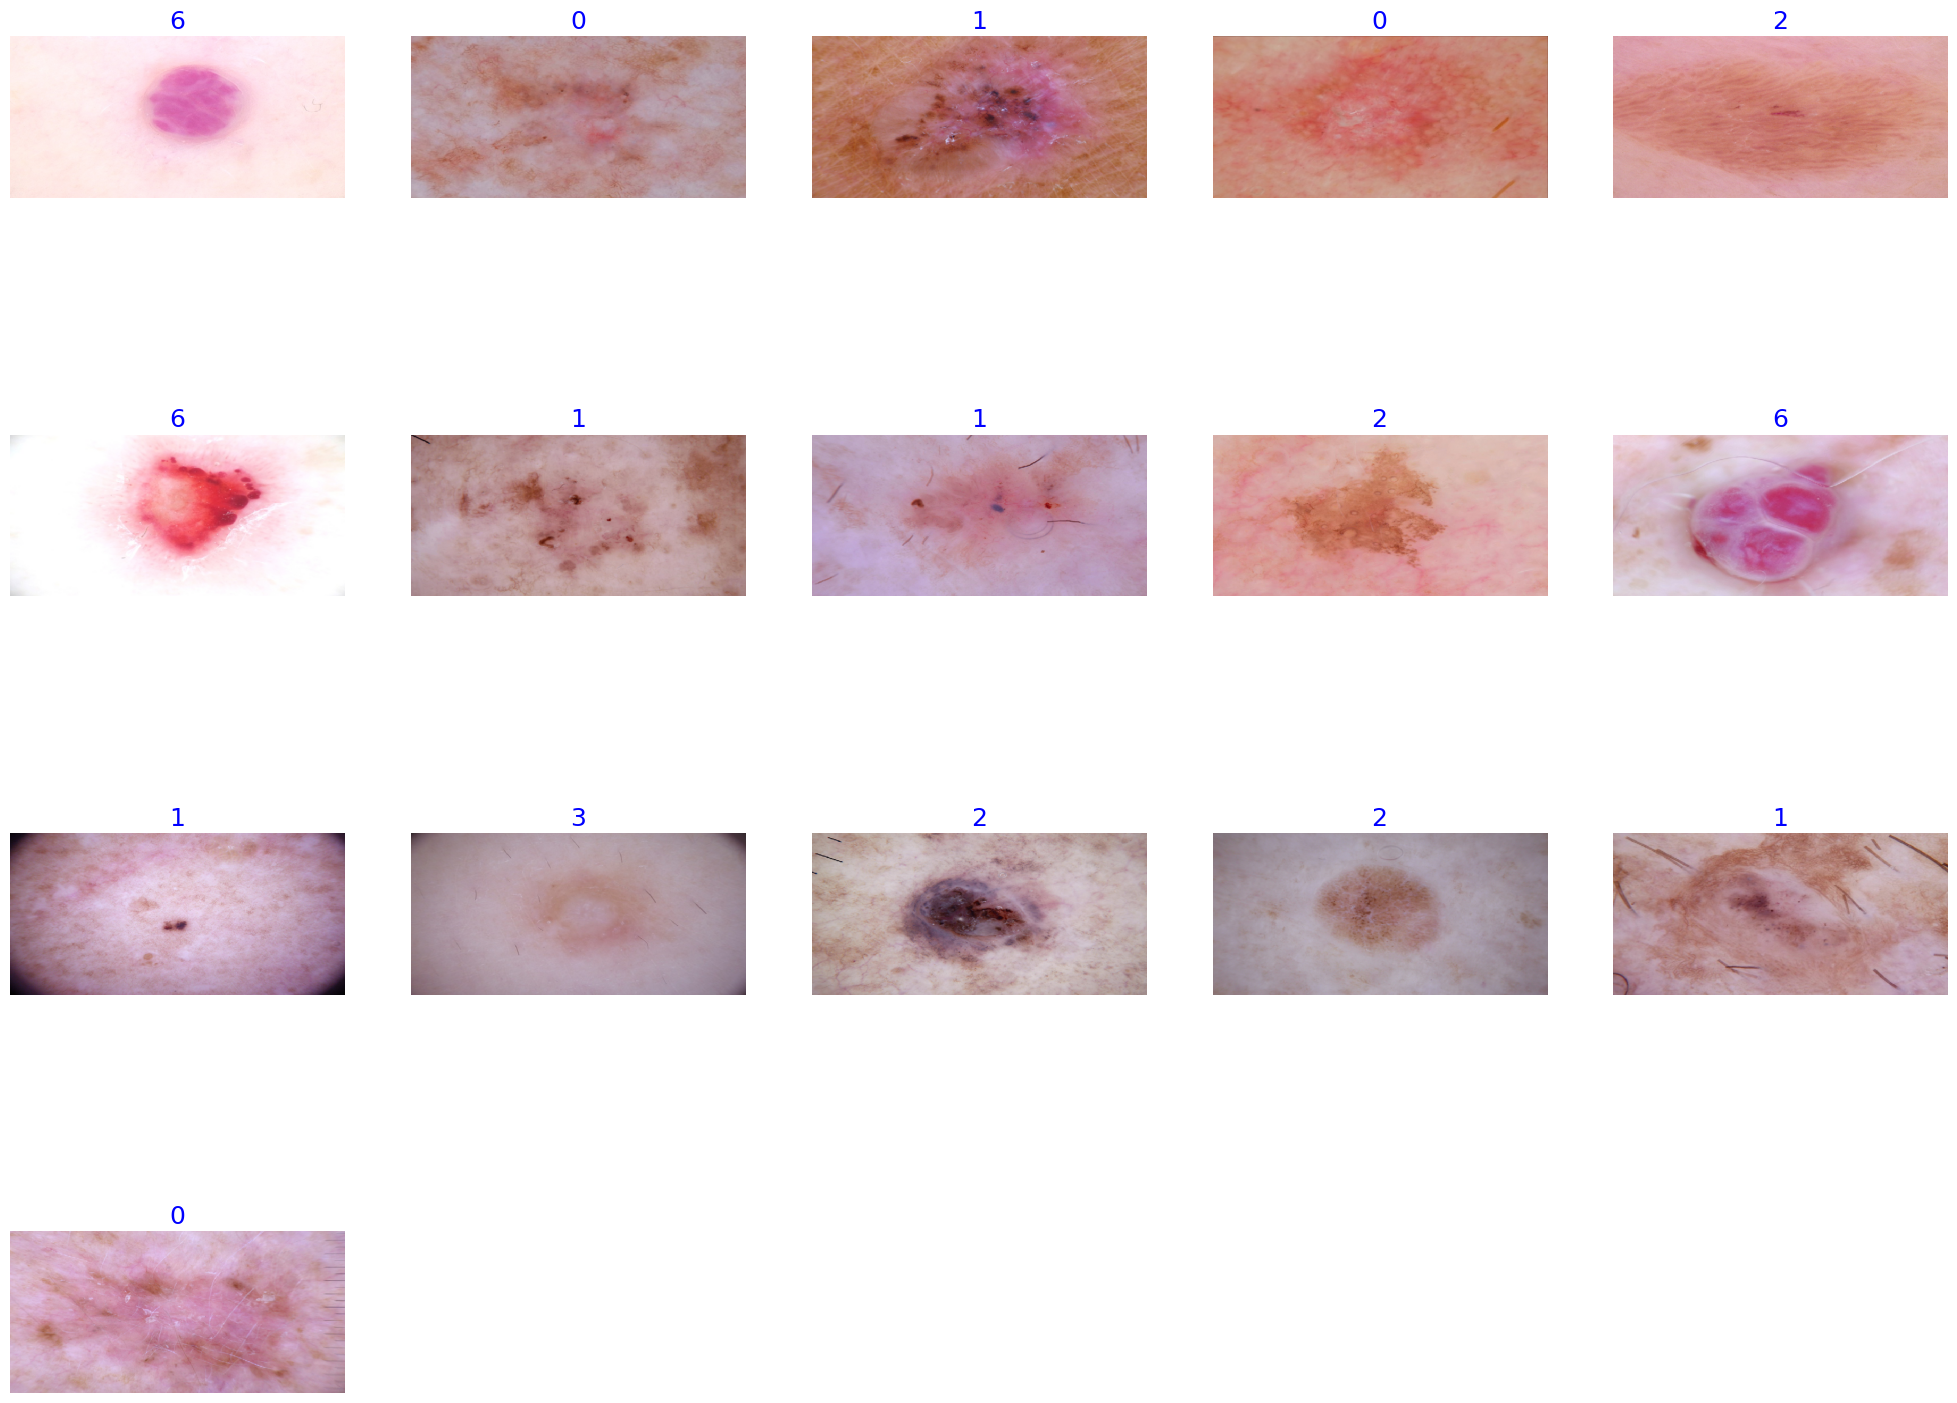

In [17]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

In [18]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [19]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [20]:
def make_model(img_size, lr, mod_num=3):
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B5 model'

    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'

    base_model.trainable= True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    # Evidential Begins
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score, 'AUC'])
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

lr=.001
model=make_model(img_size, lr)

43941136/43941136 [==============================] - 0s 0us/step
Created EfficientNet B3 model with initial learning rate set to 0.001



In [21]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor

    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to'
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started

    def on_train_end(self, logs=None):   # runs at the end of training
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss
            pimprov=(deltav/self.lowest_vloss) * 100
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights

        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='press enter to continue or enter a comment  below '
                print_in_color(msg)
                comment=input(' ')
                if comment !='':
                    comment = 'User comment: ' + comment
                    print_in_color(comment, (155,245,66))
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()

                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print_in_color(msg) # cyan foreground

In [23]:
epochs = 16
ask_epoch = 5
ask=LR_ASK(model, epochs,  ask_epoch)

In [24]:
history=model.fit(x=train_gen,   epochs=epochs, verbose=1,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch 1/16
438/438 [==============================] - 600s 1s/step - loss: 6.7342 - accuracy: 0.6606 - F1_score: 0.6358 - auc: 0.9182 - val_loss: 4.8654 - val_accuracy: 0.7083 - val_F1_score: 0.6920 - val_auc: 0.9565
Epoch 2/16
438/438 [==============================] - 564s 1s/step - loss: 3.5305 - accuracy: 0.8141 - F1_score: 0.8021 - auc: 0.9770 - val_loss: 2.7439 - val_accuracy: 0.7333 - val_F1_score: 0.7193 - val_auc: 0.9654
Epoch 3/16
438/438 [==============================] - 565s 1s/step - loss: 1.9146 - accuracy: 0.8767 - F1_score: 0.8646 - auc: 0.9882 - val_loss: 1.6588 - val_accuracy: 0.7612 - val_F1_score: 0.7524 - val_auc: 0.9694
Epoch 4/16
438/438 [==============================] - 563s 1s/step - loss: 1.1038 - accuracy: 0.9069 - F1_score: 0.8994 - auc: 0.9922 - val_loss: 1.1038 - val_accuracy: 0.8222 - val_F1_score: 0.8128 - val_auc: 0.9734
Epoch 5/16
438/438 [==============================] - 564s 1s/step - loss: 0.6943 - accuracy: 0.9356 - F1_score: 0.9288 - auc: 0.995

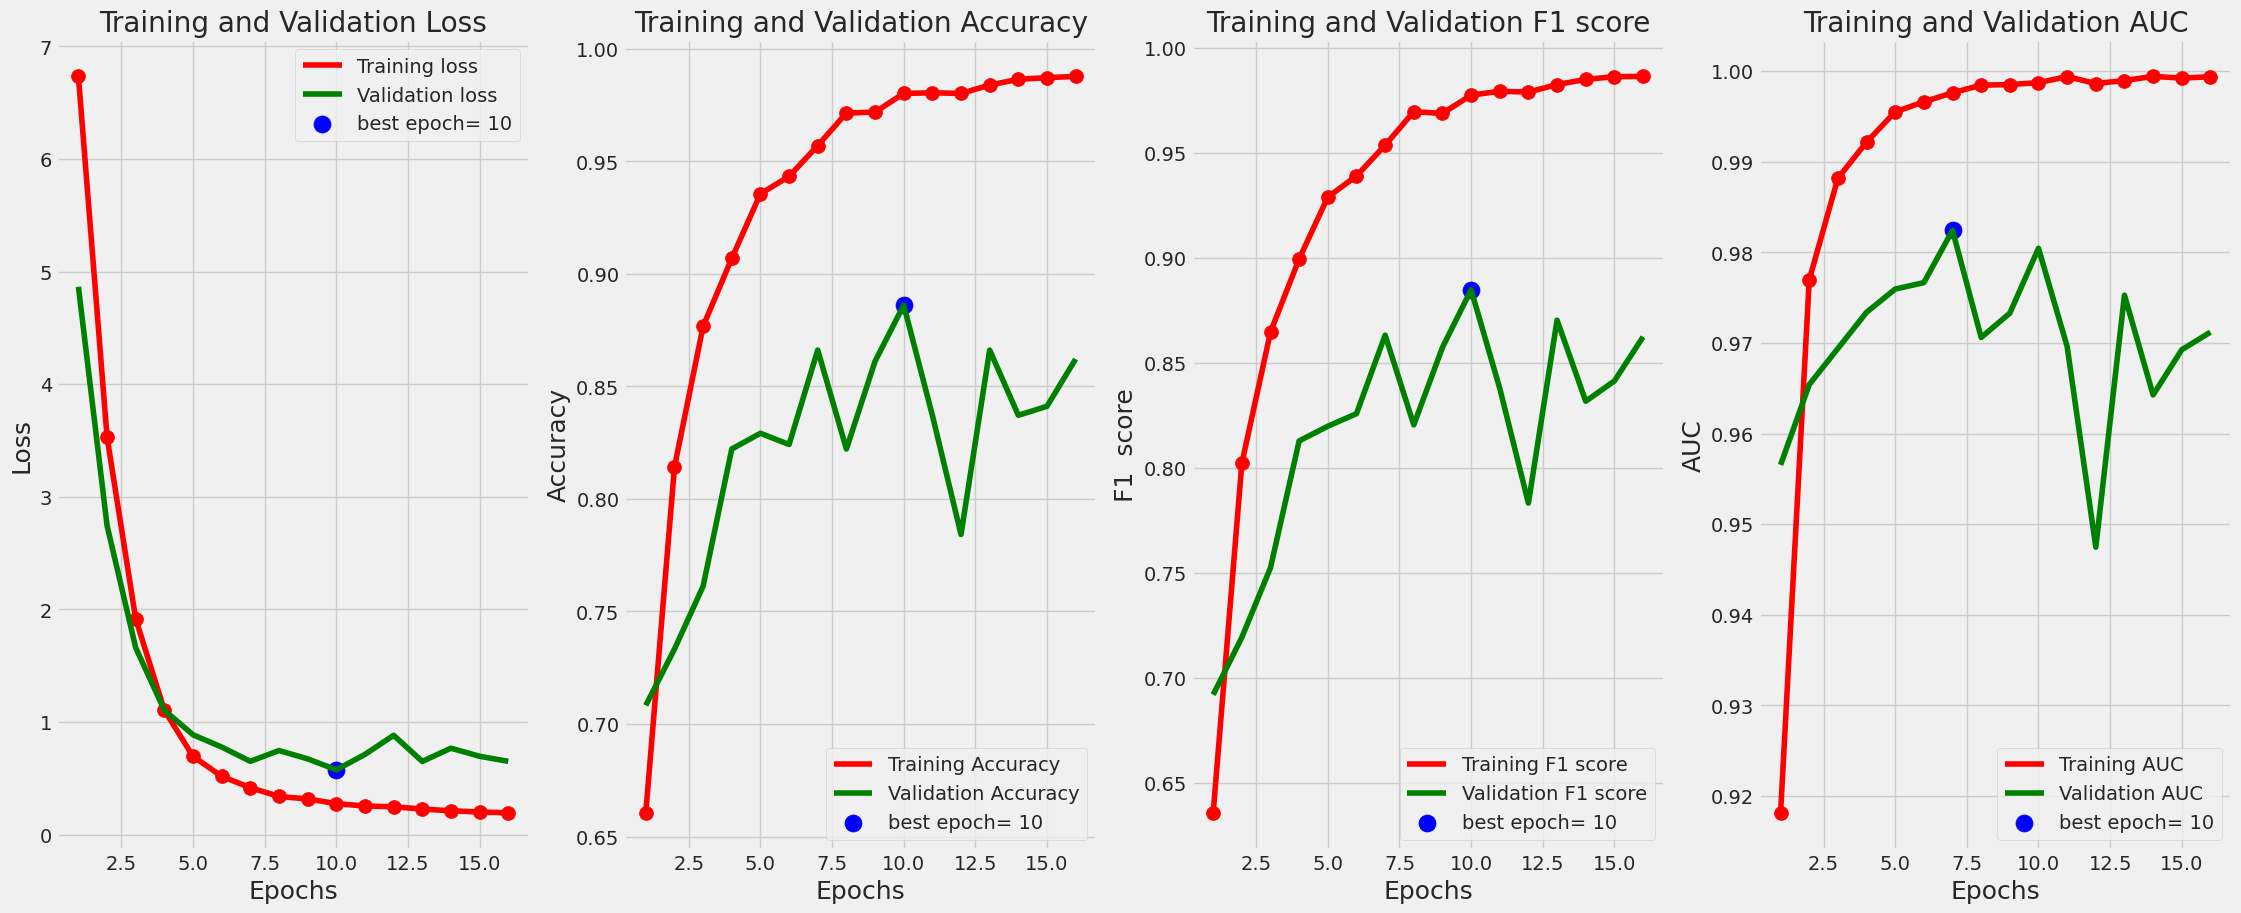

In [25]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']
    tauc=tr_data.history['auc']
    vauc=tr_data.history['val_auc']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    auc_index=np.argmax(vauc)
    val_highest_auc=vauc[auc_index]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    auc_label='best epoch= ' + str(auc_index + 1 + start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=4, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()
    axes[3].plot(Epochs,tauc, 'r', label='Training AUC')
    axes[3].plot(Epochs,vauc,'g',label='Validation AUC' )
    axes[3].scatter(auc_index+1 +start_epoch,val_highest_auc, s=150, c= 'blue', label=sc_label)
    axes[3].scatter(Epochs, tauc, s=100, c='red')
    axes[3].set_title('Training and Validation AUC')
    axes[3].set_xlabel('Epochs', fontsize=18)
    axes[3].set_ylabel('AUC', fontsize=18)
    axes[3].legend()
    plt.tight_layout
    plt.show()
    return

tr_plot(history)

In [26]:
model.save('efficientnet_model.h5')

In [27]:
model.save_weights('efficientnet_weights.h5')


In [28]:
model_json = model.to_json()
with open('efficientnet_architecture.json', 'w') as json_file:
    json_file.write(model_json)

In [30]:
model.evaluate(valid_gen)

63/63 [==============================] - 16s 244ms/step - loss: 0.6498 - accuracy: 0.8621 - F1_score: 0.8623 - auc: 0.9712


[0.6497906446456909, 0.8621378540992737, 0.8622631430625916, 0.9711953997612]